In [792]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [793]:
data = pd.read_csv('train.csv')

In [794]:
# drop redundant columns
data = data[['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'NumMosquitos', 'WnvPresent']]

In [795]:
# calculate the total number of mos for one trap each day
mos = data.groupby(['Date', 'Species', 'Trap', 'Latitude', 'Longitude']).NumMosquitos.sum()

In [796]:
wnv = data.groupby(['Date', 'Species', 'Trap', 'Latitude', 'Longitude']).WnvPresent.sum()

In [797]:
# put number of mos and virus present back together
df = pd.concat([mos, wnv], axis=1)

In [798]:
df.reset_index(level=['Date', 'Species', 'Trap', 'Latitude', 'Longitude'], inplace=True)

In [799]:
df.WnvPresent = df.WnvPresent.apply(lambda x: 1 if x>=1 else 0)

In [800]:
df.Date = pd.to_datetime(df.Date)

In [801]:
weather = pd.read_csv("weather.csv")

In [802]:
weather.drop('CodeSum', axis=1, inplace=True)

In [805]:
weather = weather.replace('M', -1)
weather = weather.replace('-', -1)
weather = weather.replace('T', -1)
weather = weather.replace(' T', -1)
weather = weather.replace('  T', -1)

In [806]:
weather.Tavg = pd.to_numeric(weather.Tavg)

### put weather data for each day in one row

In [807]:
weather1 = weather[weather['Station']==1]
weather2 = weather[weather['Station']==2]
weather1 = weather1.drop('Station', axis=1)
weather2 = weather2.drop('Station', axis=1)

In [808]:
weather1.columns = weather1.columns + str(1)

In [809]:
weather1.rename(columns={'Date1': 'Date'}, inplace=True)

In [810]:
weather2.columns = weather2.columns +str(2)

In [811]:
weather2.rename(columns={'Date2': 'Date'}, inplace=True)

In [812]:
weather = weather1.merge(weather2, on='Date')

In [813]:
weather.Date = pd.to_datetime(weather.Date)

In [815]:
df = pd.merge(df, weather, on='Date', how='left')

In [816]:
df['Year'] = df.Date.dt.year
df['Month'] = df.Date.dt.month
df['Week'] = df.Date.dt.week
df['Day'] = df.Date.dt.day

### try to utilize spray data

In [817]:
spray = pd.read_csv("spray.csv")

In [818]:
df['merge_latitude'] = df.Latitude.apply(lambda x: round(x, 2))

In [819]:
df['merge_longitude'] = df.Longitude.apply(lambda x: round(x, 2))

In [820]:
spray['merge_latitude'] = spray.Latitude.apply(lambda x: round(x, 2))
spray['merge_longitude'] = spray.Longitude.apply(lambda x: round(x, 2))

In [821]:
spray.Date = pd.to_datetime(spray.Date)

In [822]:
spray['Year'] = spray.Date.dt.year
spray['Week'] = spray.Date.dt.week

In [823]:
spray['Spray1'] = 1

In [824]:
spray.drop('Time', axis=1, inplace=True)

In [825]:
spray = spray.iloc[:, 3:]

In [826]:
spray['Week2'] = spray.Week + 1
spray['Week3'] = spray.Week + 2
spray['Spray2'] = 1
spray['Spray3'] = 1

In [827]:
spray.drop_duplicates(keep='first', inplace=True)

In [828]:
spray_week1 = spray[['merge_latitude', 'merge_longitude', 'Year', 'Week', 'Spray1']]

In [829]:
spray_week2 = spray[['merge_latitude', 'merge_longitude', 'Year', 'Week2', 'Spray2']]
spray_week2.rename(columns={'Week2':'Week'}, inplace=True)

In [830]:
spray_week3 = spray[['merge_latitude', 'merge_longitude', 'Year', 'Week3', 'Spray3']]
spray_week3.rename(columns={'Week3':'Week'}, inplace=True)

In [831]:
df = pd.merge(df, spray_week1, how = 'left', on=['Year', 'Week', 'merge_latitude', 'merge_longitude'])

In [832]:
df = pd.merge(df, spray_week2, how = 'left', on=['Year', 'Week', 'merge_latitude', 'merge_longitude'])

In [833]:
df = pd.merge(df, spray_week3, how = 'left', on=['Year', 'Week', 'merge_latitude', 'merge_longitude'])

In [834]:
# Get rid of NaNs. Replace them with 0s.
df.Spray1 = df.Spray1.apply(lambda x: 1 if x == 1 else 0)
df.Spray2 = df.Spray2.apply(lambda x: 1 if x == 1 else 0)
df.Spray3 = df.Spray3.apply(lambda x: 1 if x == 1 else 0)

In [835]:
df['Sprayed'] = df.Spray1 + df.Spray2 + df.Spray3

In [836]:
df.drop(['merge_latitude', 'merge_longitude', 'Spray1', 'Spray2', 'Spray3'], axis=1, inplace=True)

In [837]:
df.drop(['Date', 'Month', 'Day'], axis=1, inplace=True)

In [838]:
df['wnv'] = df.WnvPresent

In [839]:
df.drop('WnvPresent', axis=1, inplace=True)

In [841]:
df.to_csv('~/desktop/wnv.csv', index=False)

### Done with cleaning.

In [842]:
df = pd.read_csv('~/desktop/wnv.csv')

In [844]:
le = LabelEncoder()
cols = [i for i in df.select_dtypes(include=['object']).columns]
df[cols] = df[cols].apply(le.fit_transform)

In [845]:
X = df.iloc[:,0:-1]
y = df.wnv

### Feature Selection

In [846]:
rf = RandomForestClassifier()
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [847]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

,importance
NumMosquitos,0.248616
Longitude,0.163354
Trap,0.155980
Latitude,0.144662
Species,0.070797
Week,0.020573
Sunrise1,0.014747
Sunset1,0.014670
ResultDir2,0.009794
WetBulb1,0.009155


In [848]:
X = df[['Longitude', 'Latitude', 'Species', 'Sunrise1', 'Week']]

### Try Random Forest

In [849]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=df.wnv, random_state=42)

In [530]:
rf_params = {'n_estimators': [5, 10, 15, 20, 30], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt', 'log2', None],
            'max_depth': [3, 5, 10, None]}
rfgs = GridSearchCV(rf, rf_params, scoring='roc_auc')
rfgs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='log2',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 15, 20, 30], 'max_features': ['auto', 'sqrt', 'log2', None], 'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, 10, None]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [531]:
rfgs.score(X_test, y_test)

0.81410373094028932

In [532]:
print rfgs.best_params_

{'max_features': 'log2', 'n_estimators': 15, 'criterion': 'gini', 'max_depth': 5}


In [533]:
print rfgs.best_score_

0.826105995406


In [519]:
rf = RandomForestClassifier(max_features='log2', n_estimators=15, criterion='gini', max_depth=5, class_weight='balanced')

In [520]:
print cross_val_score(rf, X, y, cv=5, n_jobs=-1).mean()
rf_pred = cross_val_predict(rf, X, y, cv=5, n_jobs=-1)

0.690009984608


In [521]:
conmat = np.array(confusion_matrix(y, rf_pred, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['wnv', 'no wnv'], columns=['pred wnv', 'pred no wnv'])
confusion

,pred wnv,pred no wnv
wnv,302,155
no wnv,2472,5546


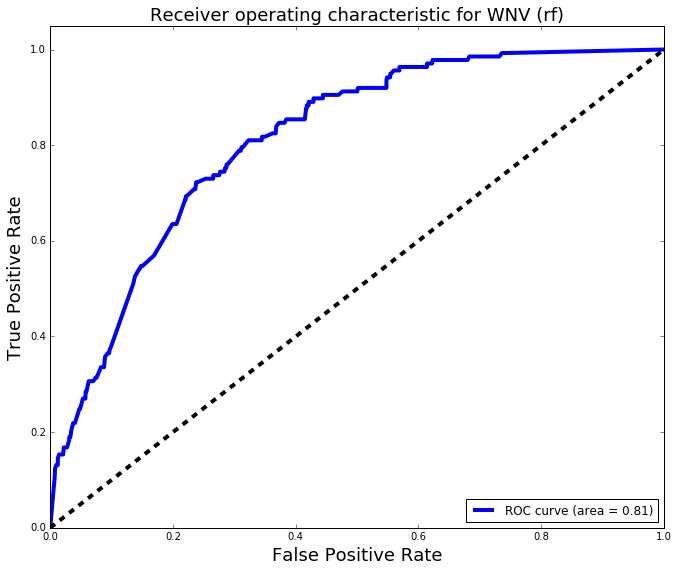

In [522]:
rf.fit(X_train, y_train)
rf_prob = rf.predict_proba(X_test)[:,1]
rffpr = dict()
rftpr = dict()
rfroc_auc=dict()
rffpr[1], rftpr[1], _ = roc_curve(y_test, rf_prob)
rfroc_auc[1] = auc(rffpr[1], rftpr[1])
plt.figure(figsize=[11,9])
plt.plot(rffpr[1], rftpr[1], label='ROC curve (area = %0.2f)' % rfroc_auc[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for WNV (rf)', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### Try SVM

In [850]:
numerical_features = ['Longitude', 'Latitude', 'Sunrise1', 'Week']
for i in numerical_features:
    df[i] = (df[i]-df[i].mean())/df[i].std()

In [851]:
## Theoratically, we should have created dummies for categorical features, but doing that brought our kaggle score down 
X = df[['Longitude', 'Latitude', 'Species', 'Sunrise1', 'Week']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=df.wnv, random_state=42)

In [645]:
clf = svm.SVC(kernel='rbf')
clf_params = {'C': 10.**np.arange(-2,3), 'gamma': 10.**np.arange(-5,2)}
clfgs = GridSearchCV(clf, clf_params, scoring='roc_auc')
clfgs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02]), 'gamma': array([  1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [633]:
clfgs.score(X_test, y_test)

0.70999356839045946

In [646]:
print clfgs.best_params_
print clfgs.best_score_

{'C': 100.0, 'gamma': 1.0}
0.724007423628


In [635]:
from sklearn.cross_validation import StratifiedKFold
cv = StratifiedKFold(df.wnv, n_folds=5, shuffle=True, random_state=7)

In [647]:
clf = svm.SVC(kernel='rbf', C=100, gamma=1, probability=True, class_weight='balanced')
clfscore = cross_val_score(clf, X, y, cv=cv, n_jobs=-1).mean()
clf_pred = cross_val_predict(clf, X, y, cv=cv, n_jobs=-1)
print clfscore

0.776637940908


In [637]:
cm_clf = np.array(confusion_matrix(y, clf_pred, labels=[1,0]))
confusion_clf = pd.DataFrame(cm_clf, index=['wnv', 'no wnv'], columns=['pred wnv', 'pred no wnv'])
confusion_clf

,pred wnv,pred no wnv
wnv,309,148
no wnv,2440,5578


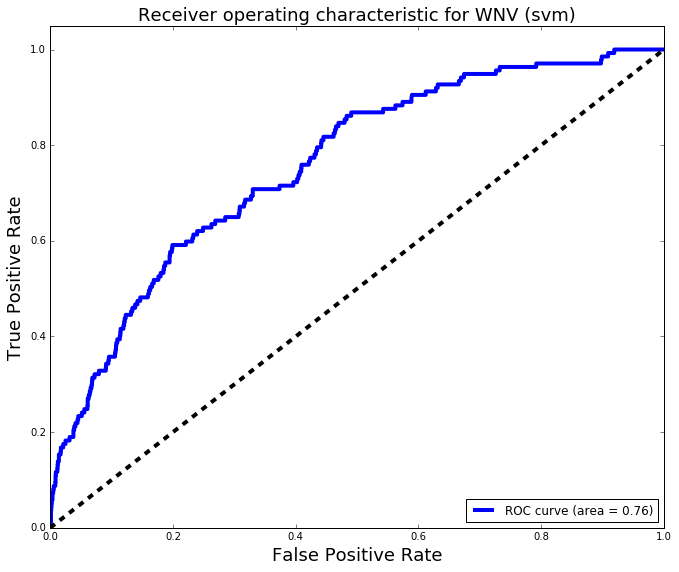

In [638]:
clf.fit(X_train, y_train)
clf_prob = clf.predict_proba(X_test)[:,1]
clffpr = dict()
clftpr = dict()
clfroc_auc=dict()
clffpr[1], clftpr[1], _ = roc_curve(y_test, clf_prob)
clfroc_auc[1] = auc(clffpr[1], clftpr[1])
plt.figure(figsize=[11,9])
plt.plot(clffpr[1], clftpr[1], label='ROC curve (area = %0.2f)' % clfroc_auc[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for WNV (svm)', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### knn

In [599]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn_params={'n_neighbors': range(3, 80), 'weights': ['uniform', 'distance']}
knngs = GridSearchCV(knn, knn_params, scoring='roc_auc')
knngs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [600]:
print knngs.best_params_
print knngs.best_score_

{'n_neighbors': 41, 'weights': 'uniform'}
0.780853899216


In [552]:
print knngs.score(X_test, y_test)

0.819276322576


In [601]:
knn = KNeighborsClassifier(n_neighbors=41, weights='uniform')

In [581]:
X_train.shape

(5932, 6)

In [602]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=41, p=2,
           weights='uniform')

### neural network

In [605]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

In [853]:
xs = X.astype(float).as_matrix()
ys = y

In [856]:
def baseline_model():
    model = Sequential()
    model.add(Dense(30, input_dim=5, init='normal', activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(30, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(30, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [789]:
xs_train, xs_test, ys_train, ys_test = train_test_split(xs, ys, test_size=0.3, stratify=df.wnv, random_state=42)

In [857]:
estimator = KerasClassifier(build_fn=baseline_model, nb_epoch=20, batch_size=50, verbose=0)

In [770]:
nngs.score(xs_test, ys_test)

0.81642457117546763

In [858]:
estimator.fit(xs_train, ys_train)
nn_prob = estimator.predict_proba(xs_test)[:,1]
nnfpr = dict()
nntpr = dict()
nnroc_auc=dict()
nnfpr[1], nntpr[1], _ = roc_curve(y_test, nn_prob)
nnroc_auc[1] = auc(nnfpr[1], nntpr[1])

In [859]:
nnroc_auc[1]

0.81698126945410188

### Naive Bayes (Gaussian)

In [777]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_prob = gnb.predict_proba(X_test)[:,1]
gnbfpr = dict()
gnbtpr = dict()
gnbroc_auc=dict()
gnbfpr[1], gnbtpr[1], _ = roc_curve(y_test, clf_prob)
gnbroc_auc[1] = auc(gnbfpr[1], gnbtpr[1])

In [778]:
gnbroc_auc[1]

0.75766484033225934

### EDA

In [121]:
import seaborn as sns

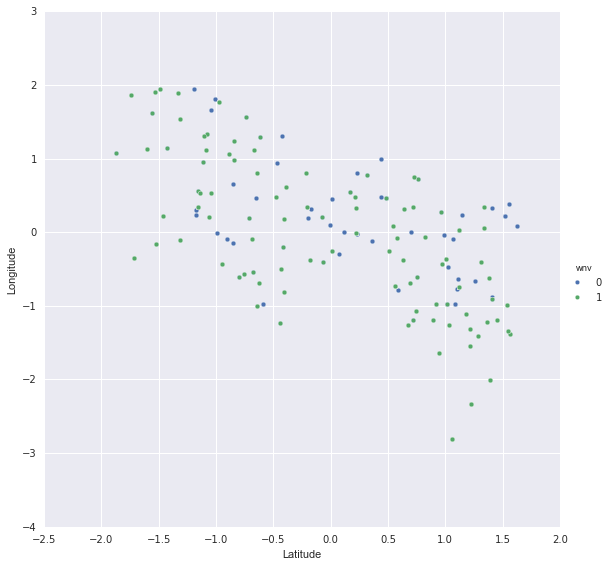

In [127]:
sns.set()
sns.pairplot(df, x_vars='Latitude', y_vars='Longitude', hue='wnv', size=8)

### submitting results

In [481]:
testing = pd.read_csv('test.csv')

In [483]:
weather_test = pd.read_csv('weather.csv')

In [484]:
weather_test = weather_test[weather_test.Station==1]

In [485]:
testing = pd.merge(left=testing, right=weather_test, on='Date', how='left')

In [490]:
testing.Date = pd.to_datetime(testing.Date)

In [491]:
testing['Week'] = testing.Date.dt.week

In [492]:
testing.Sunrise = pd.to_numeric(testing.Sunrise)

In [494]:
testing.rename(columns={'Sunrise': 'Sunrise1'}, inplace=True)

In [496]:
testing.to_csv('cleanedtest.csv', index=False)

In [573]:
testing = pd.read_csv('cleanedtest.csv')

In [575]:
for i in numerical_features:
    testing[i] = (testing[i]-testing[i].mean())/testing[i].std()

In [576]:
test_cols = [i for i in testing.select_dtypes(include=['object']).columns]
testing[test_cols] = testing[test_cols].apply(le.fit_transform)

In [683]:
X_testing = testing[['Longitude', 'Latitude', 'Species', 'Sunrise1', 'Week']]

### SVM

In [640]:
svm_test = clf.predict_proba(X_testing)[:,1]

In [641]:
testing['WnvPresent'] = svm_test

In [642]:
submit_svm = testing[['Id', 'WnvPresent']]

In [643]:
submit_svm.to_csv('score_svm.csv', index=False)

### KNN

In [604]:
knn_test = knn.predict_proba(X_testing)[:,1]
testing['WnvPresent'] = knn_test
submit_knn = testing[['Id', 'WnvPresent']]
submit_knn.to_csv('score_knn.csv', index=False)

### neural network

In [684]:
xs_testing = X_testing.as_matrix()

In [860]:
nn_test = estimator.predict_proba(xs_testing)[:,1]
testing['WnvPresent'] = nn_test
submit_nn = testing[['Id', 'WnvPresent']]
submit_nn.to_csv('score_nn1.csv', index=False)

### naive bayes (gaussian)

In [780]:
gnb_test = gnb.predict_proba(X_testing)[:,1]
testing['WnvPresent'] = gnb_test
submit_gnb = testing[['Id', 'WnvPresent']]
submit_gnb.to_csv('score_gnb.csv', index=False)